In [45]:
import sumolib
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import random

import torch
import torch_geometric
import torch_geometric.data as Data
import torch_geometric.utils as pyg_utils

import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import numpy as np




First let's read in the graph file and see if it works properly

## Data handling

In [20]:
#Function to read in the network we work with into a networkx object with the nodes and edges, no features yet
def read_sumo_net(filename):
    net = sumolib.net.readNet(filename)
    G = nx.Graph()
    
    # Add nodes
    for node in net.getNodes():
        G.add_node(node.getID(), pos=(node.getCoord()))
    # Add edges
    for edge in net.getEdges():
        for lane in edge.getLanes():
            edge_id = lane.getEdge().getID()
            starting_node_id = net.getEdge(edge_id).getFromNode().getID()
            ending_node_id = net.getEdge(edge_id).getToNode().getID()
            G.add_edge(starting_node_id, ending_node_id, edge_id = edge_id)
    return G

#Function to add the features to the network graph we created already

def add_edge_features_from_xml(G, xml_filename, interval_begin):
    # Parse the XML file
    tree = ET.parse(xml_filename)
    root = tree.getroot()
    #Find the interval corresponding to the interval_begin time 
    interval = root.find(f'.//interval[@begin="{interval_begin}"]')
    #Extract all the features of the edges
    edges = interval.findall('.//edge')
    for edge in edges:
        edge_id = edge.get('id')
        edge_features = {}
        edge_features['left'] = edge.get('left')
        #We can add other features here
        #Iterate through the edges in the existing NetworkX graph
        for xml_edge_id, xml_edge_data in G.edges.items():
            if G.get_edge_data(xml_edge_id[0],xml_edge_id[1])['edge_id'] == edge_id:
                G.edges[xml_edge_id].update(edge_features)
    return G

def nx_to_pyg(graph):
    # Convert NetworkX graph to PyTorch Geometric Data object
    pyg_data = Data.Data()
    #We have to number the nodes, because that is how Data object works
    # Mapping between string node IDs and numerical indices
    node_id_to_index = {node_id: i for i, node_id in enumerate(graph.nodes)}

    # Set node features
    num_nodes = graph.number_of_nodes()
    node_features = np.zeros((num_nodes, 2))  # Assuming num_features is known, this is important to change, if we want to change something, altough I do not think that will be the case for us
    for i, (node, features) in enumerate(graph.nodes(data=True)):
        node_features[i] = [features['pos'][0], features['pos'][1]]  # Add node features accordingly, this case the coordinates
    pyg_data.x = torch.tensor(node_features, dtype=torch.float)

    # Set edge features and edge indices
    edge_index = []
    edge_features = []
    for u, v, features in graph.edges(data=True):
        # Map string node IDs to numerical indices
        u_index = node_id_to_index[u]
        v_index = node_id_to_index[v]
        edge_index.append([u_index, v_index])
        edge_features.append([float(features['left'])])  # Add edge features accordingly, if we add more features, we have to change this line

    pyg_data.edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    pyg_data.edge_attr = torch.tensor(edge_features, dtype=torch.float)

    return pyg_data


#Function to plot the graph
def plot_graph(G):
    pos = nx.get_node_attributes(G, 'pos')
    nx.draw(G, pos, with_labels=False, node_size=1)
    plt.show()

Graph = read_sumo_net('s_gyor.net.xml')


Data(x=[413, 2], edge_index=[2, 504], edge_attr=[504, 1])


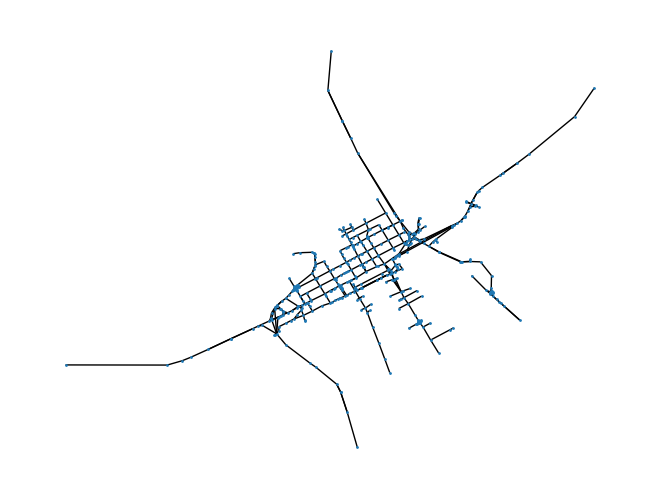

In [46]:
G1 = read_sumo_net('s_gyor.net.xml')
G2 = add_edge_features_from_xml(G1,'gyor_forg_15_min.xml',"0.00")
pyg_data = nx_to_pyg(G2)
print(pyg_data)
plot_graph(G1)

In [116]:
G2 = add_edge_features_from_xml(G1,'gyor_forg_15_min.xml',"10800.00")
G3 = add_edge_features_from_xml(G1,'gyor_forg_15_min.xml',"9000.00")
data_training = nx_to_pyg(G2)

data = torch.load('data.pth')


class GNN(nn.Module):
    def __init__(self, edge_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, hidden_dim6, hidden_dim7, hidden_dim8):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(edge_dim, hidden_dim1)
        self.conv2 = GCNConv(hidden_dim1, hidden_dim2)
        self.conv3 = GCNConv(hidden_dim2, hidden_dim3)
        self.conv4 = GCNConv(hidden_dim3, hidden_dim4)
        self.conv5 = GCNConv(hidden_dim4, hidden_dim5)
        self.conv6 = GCNConv(hidden_dim5, hidden_dim6)
        self.conv7 = GCNConv(hidden_dim6, hidden_dim7)
        self.conv8 = GCNConv(hidden_dim7, hidden_dim8)
        self.linear = nn.Linear(hidden_dim8, edge_dim)

    def forward(self, edge_features, edge_index):
        x = self.conv1(edge_features, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.conv4(x, edge_index)
        x = F.relu(x)
        x = self.conv5(x, edge_index)
        x = F.relu(x)
        x = self.conv6(x, edge_index)
        x = F.relu(x)
        x = self.conv7(x, edge_index)
        x = F.relu(x)
        x = self.conv8(x, edge_index)
        x = F.relu(x)
        x = self.linear(x)
        return x

# Assume edge features are stored in data_training.edge_attr
edge_features = data_training.edge_attr

# Normalize the edge features
max_value = edge_features.max()
normalized_edge_features = edge_features / max_value
data_training.edge_attr = normalized_edge_features
data_testing = data_training.clone()

# Get the total number of edges in the dataset
total_num_edges = data_training.num_edges

# Calculate the number of edges to hide 
num_edges_to_hide = int(total_num_edges * 0.7)
num_remaining_edges = total_num_edges - num_edges_to_hide

# Randomly select edges to hide 
edges_to_hide = random.sample(range(total_num_edges), num_edges_to_hide)
remaining_edges = list(set(range(total_num_edges)) - set(edges_to_hide))
data_training.edge_attr[edges_to_hide] = -1 #This is questionable

# Define the model
edge_dim = 1  # Number of edge features
hidden_dim1 = 32
hidden_dim2 = 128
hidden_dim3 = 64
hidden_dim4 = 32
hidden_dim5 = 32
hidden_dim6 = 32
hidden_dim7 = 32
hidden_dim8 = 32

model = GNN(edge_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, hidden_dim6, hidden_dim7, hidden_dim8)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

num_epochs = 1000
losses = np.zeros(num_epochs)
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    output = model(data_training.edge_attr, data_training.edge_index)
    
    # Compute loss using the predicted features and the input features of the hidden edges
    loss = criterion(output[edges_to_hide], data_testing.edge_attr[edges_to_hide])
    losses[epoch] = loss
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.13596518337726593
Epoch 11, Loss: 0.058121416717767715
Epoch 21, Loss: 0.057891108095645905
Epoch 31, Loss: 0.057272423058748245
Epoch 41, Loss: 0.05696101486682892
Epoch 51, Loss: 0.05678831413388252
Epoch 61, Loss: 0.05667920038104057
Epoch 71, Loss: 0.05658324062824249
Epoch 81, Loss: 0.0564565435051918
Epoch 91, Loss: 0.05630587041378021
Epoch 101, Loss: 0.05613325908780098
Epoch 111, Loss: 0.05589164420962334
Epoch 121, Loss: 0.05566950887441635
Epoch 131, Loss: 0.05559525638818741
Epoch 141, Loss: 0.05543830618262291
Epoch 151, Loss: 0.05549454689025879
Epoch 161, Loss: 0.055119846016168594
Epoch 171, Loss: 0.05478044971823692
Epoch 181, Loss: 0.054818179458379745
Epoch 191, Loss: 0.05446444824337959
Epoch 201, Loss: 0.05394081026315689
Epoch 211, Loss: 0.05357617512345314
Epoch 221, Loss: 0.055609140545129776
Epoch 231, Loss: 0.05578897148370743
Epoch 241, Loss: 0.05464653670787811
Epoch 251, Loss: 0.05435335263609886
Epoch 261, Loss: 0.05335517227649689
Epoch 2

In [7]:
def make_an_estimation(edges_to_hide, model, data_training):
    edge_features = data_training.edge_attr
    max_value = edge_features.max()
    normalized_edge_features = edge_features / max_value
    data_training.edge_attr = normalized_edge_features
    output = model(data_training.edge_attr, data_training.edge_index)
    loss = criterion(output[edges_to_hide], data_testing.edge_attr[edges_to_hide])
    return loss, output

G3 = add_edge_features_from_xml(G1,'gyor_forg_15_min.xml',"9000.00")
data_training2 = nx_to_pyg(G3)
make_an_estimation(edges_to_hide, model, data_training2)

(tensor(0.1209, grad_fn=<MseLossBackward0>),
 tensor([[ 0.1320],
         [ 0.0305],
         [ 0.5256],
         [ 0.5961],
         [ 0.5496],
         [ 0.6087],
         [ 0.6057],
         [ 0.6333],
         [ 0.7498],
         [ 0.8552],
         [ 0.3830],
         [ 0.2441],
         [ 0.2441],
         [ 0.2402],
         [ 0.2785],
         [ 0.3681],
         [ 0.2421],
         [ 0.4457],
         [ 0.3299],
         [ 0.3295],
         [ 0.4457],
         [ 0.3294],
         [ 0.3294],
         [ 0.2538],
         [ 0.3312],
         [ 0.2965],
         [ 0.3519],
         [ 0.2158],
         [ 0.2348],
         [ 0.3633],
         [ 0.3412],
         [ 0.1771],
         [ 0.1546],
         [ 0.1128],
         [ 0.0971],
         [ 0.0973],
         [ 0.7392],
         [ 0.8191],
         [ 0.4514],
         [ 0.3535],
         [ 0.4064],
         [ 0.2062],
         [ 0.2123],
         [ 0.2120],
         [ 0.2485],
         [ 0.2402],
         [ 0.1553],
         [ 0.38

## Data visualization

In [8]:
def losses_epoch_plot(losses, save, save_name):
    fig = plt.figure()
    epochs = np.linspace(start=0, stop=np.size(losses), num=np.size(losses))
    plt.scatter(epochs,losses,c='red')
    plt.ylabel('Loss', fontsize=20)
    plt.xlabel('Epochs', fontsize=20)
    plt.grid(True,which='major',color='gray')
    plt.minorticks_on()
    plt.tick_params(axis='both', which='both', direction= 'in')
    fig.set_size_inches(14,7.5)
    if save:
        plt.savefig(save_name)



def enhanced_histogram(data, bins=30, save=False, save_name='histogram.png'):
    fig = plt.figure()
    plt.hist(data, bins=bins, color='blue', edgecolor='black')
    plt.ylabel('Frequency', fontsize=20)
    plt.xlabel('Difference', fontsize=20)  # Changed to 'Difference' to reflect the data
    plt.grid(True, which='major', color='gray', linestyle='--', linewidth=0.7)
    plt.minorticks_on()
    plt.grid(True, which='minor', color='lightgray', linestyle=':', linewidth=0.5)
    plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)
    fig.set_size_inches(14, 7.5)
    plt.title('Histogram of Differences', fontsize=22)  # Changed title to reflect the data

    if save:
        plt.savefig(save_name)
    plt.show()

352


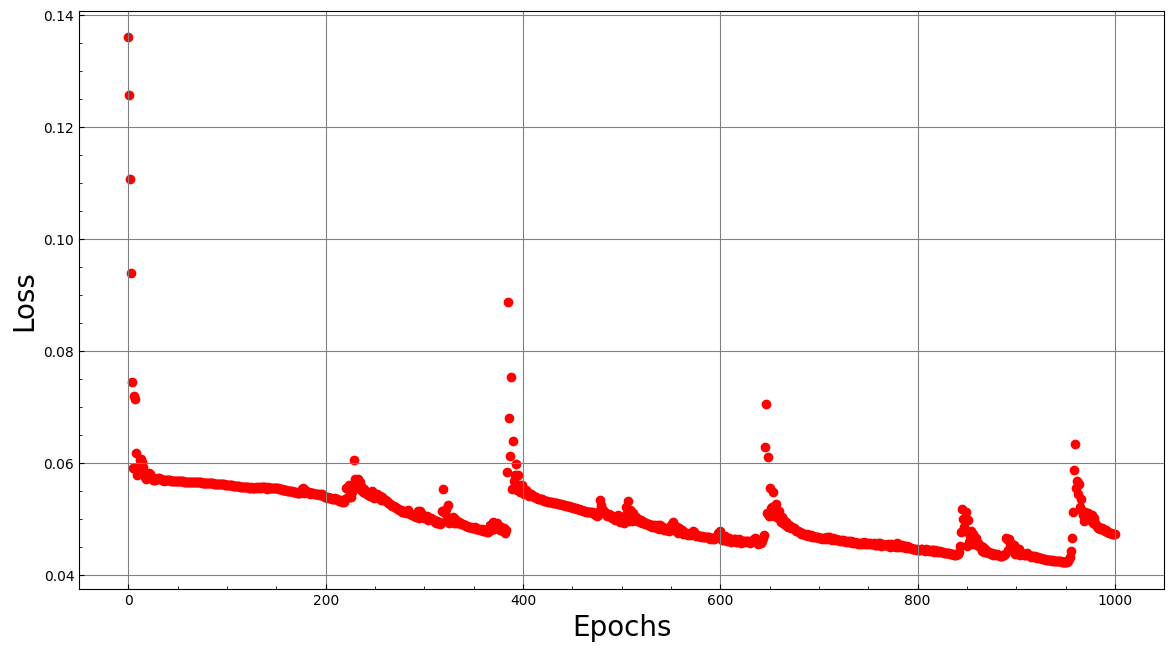

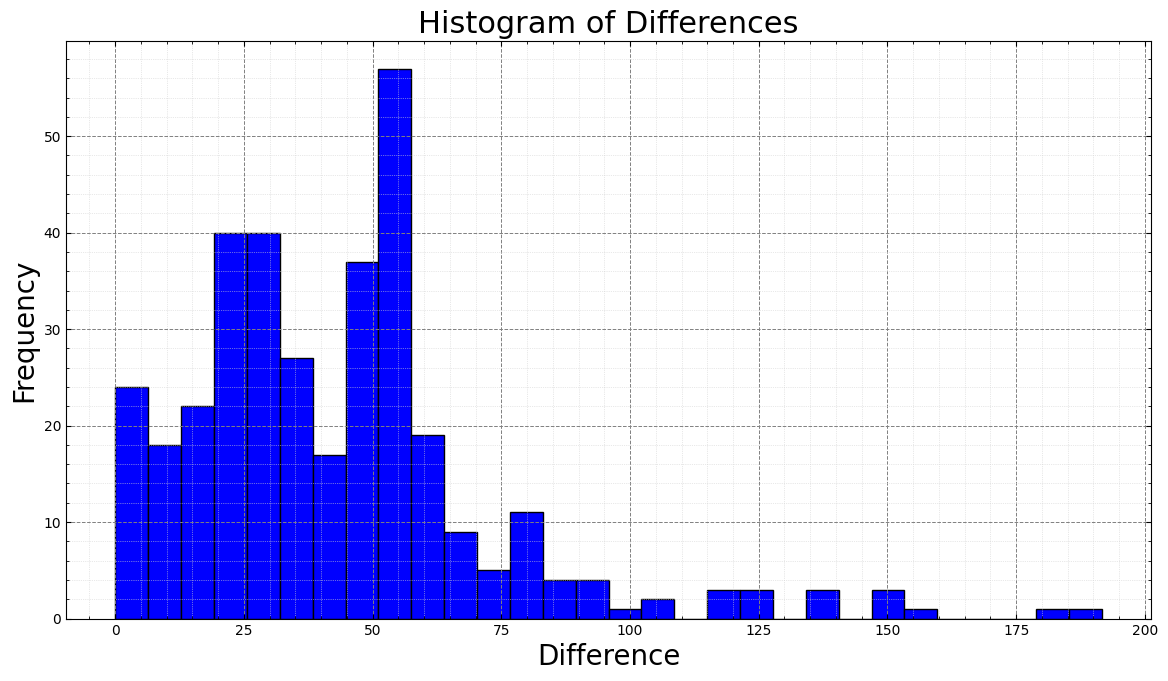

[4.85129967e+01 1.53286877e+01 2.76367226e+01 1.50132538e+02
 1.47132538e+02 1.47948904e+01 1.98182735e+01 2.78674545e+01
 3.40645943e+01 2.68230305e+01 5.49354057e+01 8.81325455e+01
 4.78674545e+01 3.49354057e+01 6.02479696e+00 3.71788788e+01
 3.05992165e+01 6.41325455e+01 2.48674545e+01 2.81325417e+01
 8.18000565e+01 6.31325455e+01 7.58677959e+00 1.25507698e+02
 5.61727524e+01 6.33236580e+01 2.61899948e+01 2.48674545e+01
 5.85501289e+01 5.58266068e+01 8.81325455e+01 1.17483597e+01
 1.49612246e+01 3.86745644e+00 6.30571594e+01 3.40645943e+01
 3.53031120e+01 5.38674545e+01 2.81325417e+01 3.79986906e+00
 2.19178104e+01 5.54571304e+01 5.68903084e+01 2.01325436e+01
 5.68266068e+01 1.54931965e+01 1.96058059e+00 5.61584091e+01
 2.89552917e+01 2.50567837e+01 3.13737202e+01 1.47948904e+01
 1.07714966e+02 4.38674545e+01 5.38674545e+01 1.18674545e+01
 5.38674545e+01 5.00645943e+01 2.75426445e+01 2.56811600e+01
 8.89913101e+01 6.33861351e+01 5.00645943e+01 9.44510174e+00
 9.05060501e+01 2.042714

In [117]:
losses_epoch_plot(losses,False,'asd')

N = num_edges_to_hide
print(N)
difference = np.zeros(N)
for i in range(N):
    if output[edges_to_hide][i]<0:
        output[edges_to_hide][i] = 0
    difference[i] = max_value * float(abs(output[edges_to_hide][i] - data_testing.edge_attr[edges_to_hide][i]))
    #print(output[edges_to_hide][i])
enhanced_histogram(difference, bins=30, save=False, save_name='enhanced_histogram.png')
print(difference)

352
[(0.5019607843137255, 0.574794309880815, 0.0, 1.0), (0.1568627450980392, 0.524721261053441, 0.0, 1.0), (0.2823529411764706, 0.5429296424452134, 0.0, 1.0), (1.0, 0.279123414071511, 0.0, 1.0), (1.0, 0.2994232987312574, 0.0, 1.0), (0.14901960784313725, 0.5235832372164552, 0.0, 1.0), (0.20392156862745098, 0.5315494040753557, 0.0, 1.0), (0.2901960784313725, 0.5440676662821992, 0.0, 1.0), (0.3529411764705882, 0.5531718569780854, 0.0, 1.0), (0.27450980392156865, 0.5417916186082277, 0.0, 1.0), (0.5725490196078431, 0.585036524413687, 0.0, 1.0), (0.9176470588235294, 0.6351095732410612, 0.0, 1.0), (0.49411764705882355, 0.5736562860438293, 0.0, 1.0), (0.3607843137254902, 0.5543098808150712, 0.0, 1.0), (0.06274509803921569, 0.5110649750096117, 0.0, 1.0), (0.38431372549019605, 0.5577239523260284, 0.0, 1.0), (0.3137254901960784, 0.5474817377931565, 0.0, 1.0), (0.6666666666666666, 0.5986928104575163, 0.0, 1.0), (0.2588235294117647, 0.5395155709342561, 0.0, 1.0), (0.2901960784313725, 0.544067666282

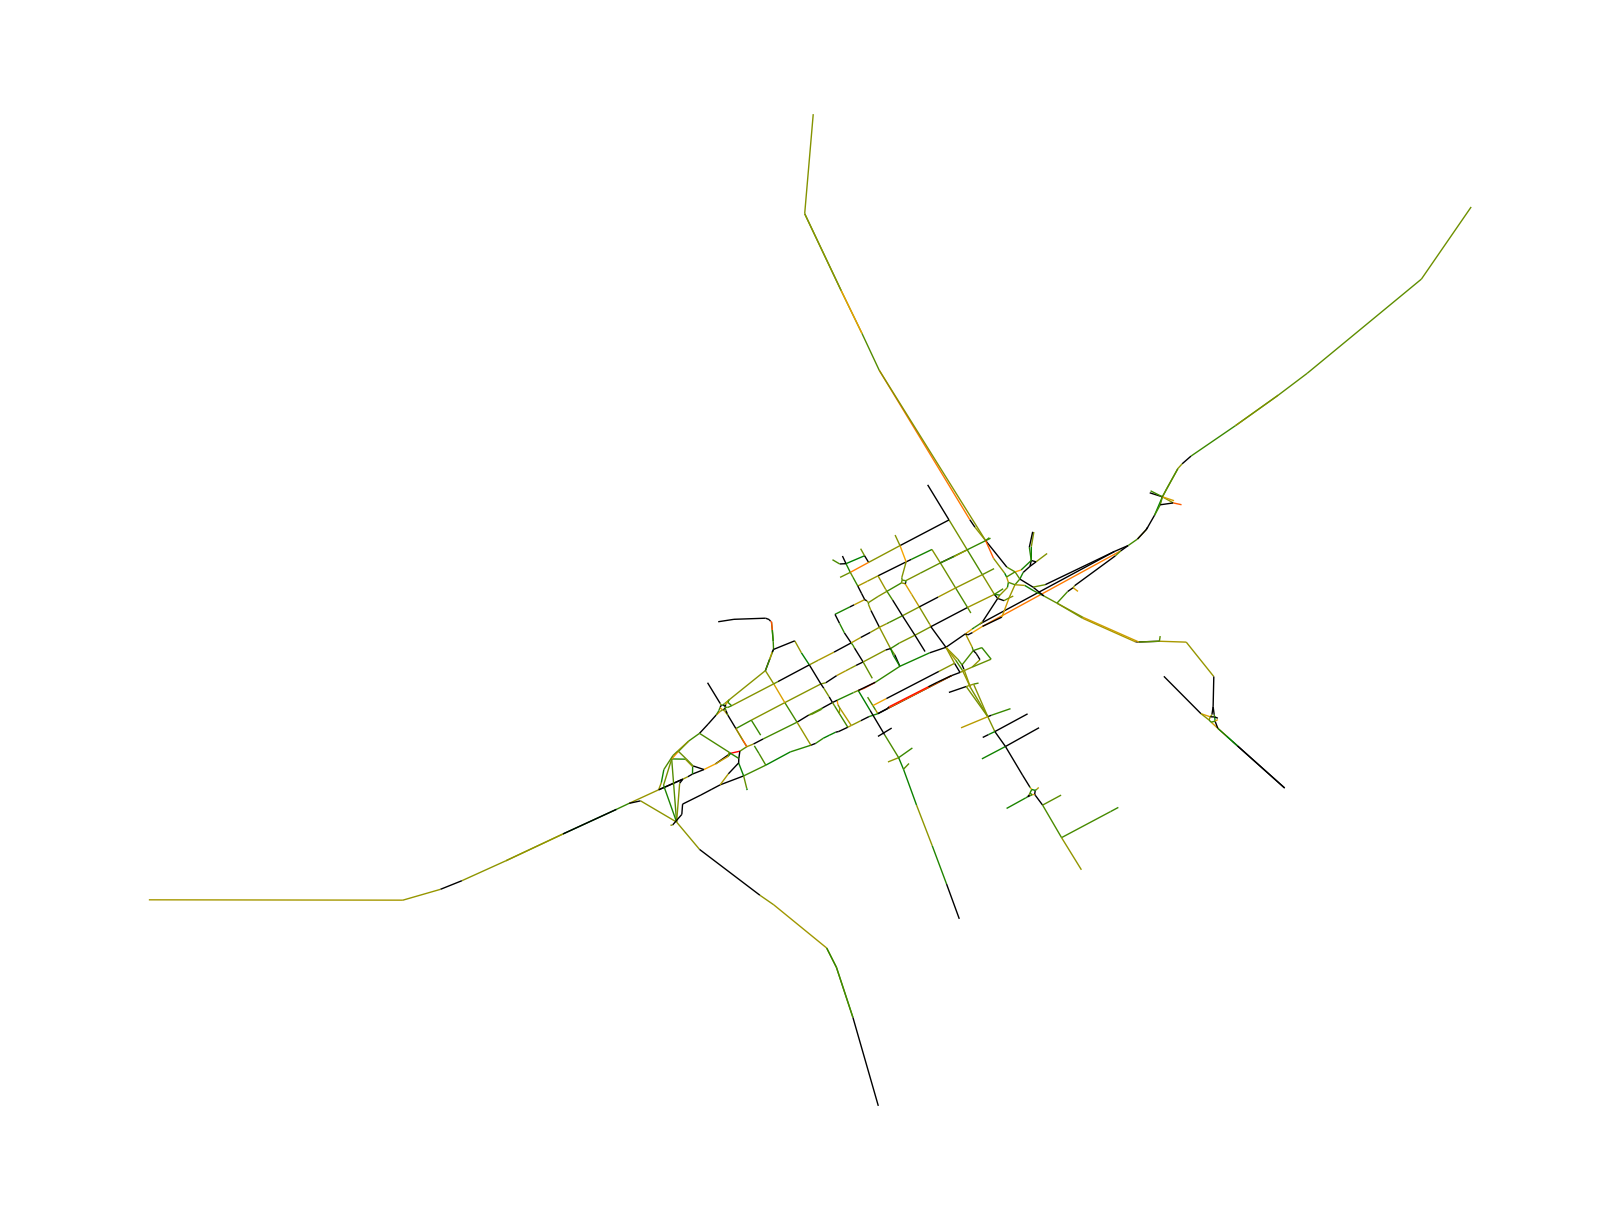

In [137]:
def plot_graph_weight(G):
    plt.figure(figsize=(16,12))
    pos = nx.get_node_attributes(G, 'pos')
    N = num_edges_to_hide
    print(N)
    difference = np.zeros(N)
    for i in range(N):
        if output[edges_to_hide][i]<0:
            output[edges_to_hide][i] = 0
        difference[i] = max_value * float(abs(output[edges_to_hide][i] - data_testing.edge_attr[edges_to_hide][i]))

    maxdiff = max(difference)

    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green","orange", "red"])
    colors = [cmap(c/maxdiff) for c in difference]
    
    print(colors)

    edge_colors = {edge: 'black' for edge in G.edges()}


    edges_to_color_edges = []
    edges=list(G2.edges())
    edges_to_color_by_id=[]

    for i in edges_to_hide:
        edges_to_color_edges.append(edges[i])
    for i in edges_to_color_edges:
        edges_to_color_by_id.append(G2.edges[i]['edge_id'])

    colorindexiter=0
    for edge in G.edges():
        edge_id = G.edges[edge]['edge_id']


        if edge_id in edges_to_color_by_id:

            edge_colors[edge] = colors[colorindexiter]
            colorindexiter+=1

    nx.set_edge_attributes(G, edge_colors, 'color')

    edge_color_values = [G[u][v]['color'] for u, v in G.edges()]
    options = {
        

        "width": 1,
        "edge_cmap": plt.cm.Blues,
        "with_labels": False,
    }
    nx.draw(G, pos, **options, edge_color=edge_color_values, node_size=0) 

    plt.show()
    
plot_graph_weight(G2) 